# Foundation models for zero-shot detection and segmentation

Based on [Ollama](https://github.com/ollama/ollama) project.

In [1]:
!curl -L https://ollama.com/download/ollama-linux-amd64 -o ollama
!chmod +x ollama
!./ollama pull llava
#!cp ./ollama /usr/bin/ollama

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   112  100   112    0     0    505      0 --:--:-- --:--:-- --:--:--   506
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  558M  100  558M    0     0   123M      0  0:00:04  0:00:04 --:--:--  139M


In [25]:
import subprocess
subprocess.Popen(["./ollama", "serve"])
import time
time.sleep(3) # Wait for a few seconds for Ollama to load!

In [ ]:
!wget -q -O xxx.jpg https://github.com/ant-nik/neural_network_course/blob/main/practice_2_data/video_1_fixed/image_001.jpg?raw=true

In [42]:
%%writefile prompt.txt
Find entities on the image.
Split answer in two sections a LIST and a EXPLANATION.
Put only detected object names to the LIST section.
Put an explanation of the answer into the EXPLANATION section

Overwriting prompt.txt


In [43]:
!echo '{ "model": "llava", "prompt": "'`cat prompt.txt`'", "images": ["'`base64 -w 0 /content/xxx.jpg`'"], "stream": false}' > body.json

In [44]:
!curl http://localhost:11434/api/generate --data-binary "@body.json"

{"model":"llava","created_at":"2024-08-01T09:43:31.910512125Z","response":" LIST:\n1. Bottle\n2. Man\n3. Water bottle\n4. Rocks\n5. Dirt\n6. Trash bag\n7. Grass\n8. River\n9. Dogs (if any)\n10. Mountain\n\nEXPLANATION:\nThe image shows a man outside in a natural environment. He appears to be bending over, possibly interacting with the ground or some kind of litter in his hands. There is a bottle near him, and it seems like he might be picking up trash from the area. The landscape suggests a rural or semi-rural setting with rocks, dirt, grass, and what could be a small river or stream visible in the background. Additionally, there appears to be a trash bag nearby, which supports the idea that the man is cleaning up litter. ","done":true,"done_reason":"stop","context":[733,16289,28793,733,5422,28733,28734,28793,13,13,10779,19810,356,272,3469,28723,318,3255,4372,297,989,12458,264,393,8048,304,264,4175,3898,1251,4866,28723,10331,865,15538,1928,2955,298,272,393,8048,4211,28723,10331,396,132

In [63]:
%%writefile step-2-prompt.txt
Extract text between LIST and EXPLANATION sections and consider it as TEXT in the instruction below.
Split answer in two parts: OUTPUT and INFO.
Remove any enumeration symbols in the TEXT and place only one list entity per line to the OUTPUT section between START and END markers.
Put any explanation of the answer to INFO section.

LIST:
1. Bottle
2. Man
3. Water bottle
4. Rocks
5. Dirt
6. Trash bag
7. Grass
8. River
9. Dogs (if any)
10. Mountain

EXPLANATION:
The image shows a man outside in a natural environment. He appears to be bending over, possibly interacting with the ground or some kind of litter in his hands. There is a bottle near him, and it seems like he might be picking up trash from the area. The landscape suggests a rural or semi-rural setting with rocks, dirt, grass, and what could be a small river or stream visible in the background. Additionally, there appears to be a trash bag nearby, which supports the idea that the man is cleaning up litter.

OUTPUT:


Overwriting step-2-prompt.txt


In [64]:
!echo '{ "model": "llama3.1", "prompt": "'`cat step-2-prompt.txt`'", "stream": false}' > step-2-body.json

In [65]:
!curl --data-binary "@step-2-body.json" -o step-2-result.txt http://localhost:11434/api/generate

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3426    0  2391  100  1035      9      4  0:04:18  0:04:14  0:00:04   684


In [67]:
import json

with open("step-2-result.txt", "r") as file:
    step2_response = json.loads(file.read())
print(step2_response["response"])

**OUTPUT**
START
Bottle
Man
Water bottle
Rocks
Dirt
Trash bag
Grass
River
Dogs (if any)
Mountain
END

**INFO**
The instruction was to split the answer into two parts: OUTPUT and INFO, where the TEXT between LIST and EXPLANATION sections is considered as TEXT. The OUTPUT section contains each list entity on a new line, without enumeration symbols. The INFO section explains that this process was performed to reorganize the original list provided in the TEXT, based on the given instructions.


In [79]:
objects = [item for item in step2_response["response"].split("START")[1].split("END")[0].split("\n") if not item=='']

In [119]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model_id = "IDEA-Research/grounding-dino-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image_url = "https://drive.usercontent.google.com/u/0/uc?id=1Abxa12JrIk-R2iupQL0nEH5MWPWtD2H1&export=download"
image = Image.open("xxx.jpg")

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.1,
    text_threshold=0.1,
    target_sizes=[image.size[::-1]]
)
results

[{'scores': tensor([0.4413, 0.8043, 0.8489, 0.3475, 0.2772, 0.3042, 0.2900, 0.2458, 0.2250,
          0.2745, 0.2724, 0.3946, 0.2444, 0.2051, 0.1337, 0.2348, 0.1979, 0.2054,
          0.2047, 0.2162, 0.2464, 0.1493, 0.1990, 0.1572, 0.1954, 0.2051, 0.1801,
          0.1050, 0.1319, 0.1520, 0.1245, 0.1127, 0.2904, 0.1517, 0.1250, 0.1115,
          0.1551, 0.1454, 0.1133, 0.2807, 0.1142, 0.1234, 0.1580, 0.1004, 0.1400,
          0.1101, 0.1035, 0.1218, 0.1189, 0.1184, 0.1000, 0.1091, 0.1052, 0.1205,
          0.1327, 0.1652, 0.2471, 0.1175, 0.1656, 0.1105, 0.1077, 0.1015, 0.1015,
          0.1384, 0.1593, 0.1196, 0.1017]),
  'labels': ['bottle water bottle',
   'man',
   'bottle water bottle',
   'rocks dirt',
   'rocks',
   'rocks',
   'grass',
   'rocks',
   'rocks',
   'grass',
   'rocks',
   'rocks dirt',
   'rocks',
   'rocks',
   'rocks',
   'rocks',
   'grass',
   'rocks',
   'rocks dirt',
   'rocks',
   'rocks',
   'grass',
   'rocks',
   'dirt',
   'trash bag',
   'rocks',
   'ro

In [122]:
# VERY important: text queries need to be lowercased + end with a dot
text = " . ".join([f"all {item}" for item in objects]).lower() + '.'
print(text)

all bottle . all man . all water bottle . all rocks . all dirt . all trash bag . all grass . all river . all dogs (if any) . all mountain.


In [81]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 4.7 MB/s eta 0:00:00


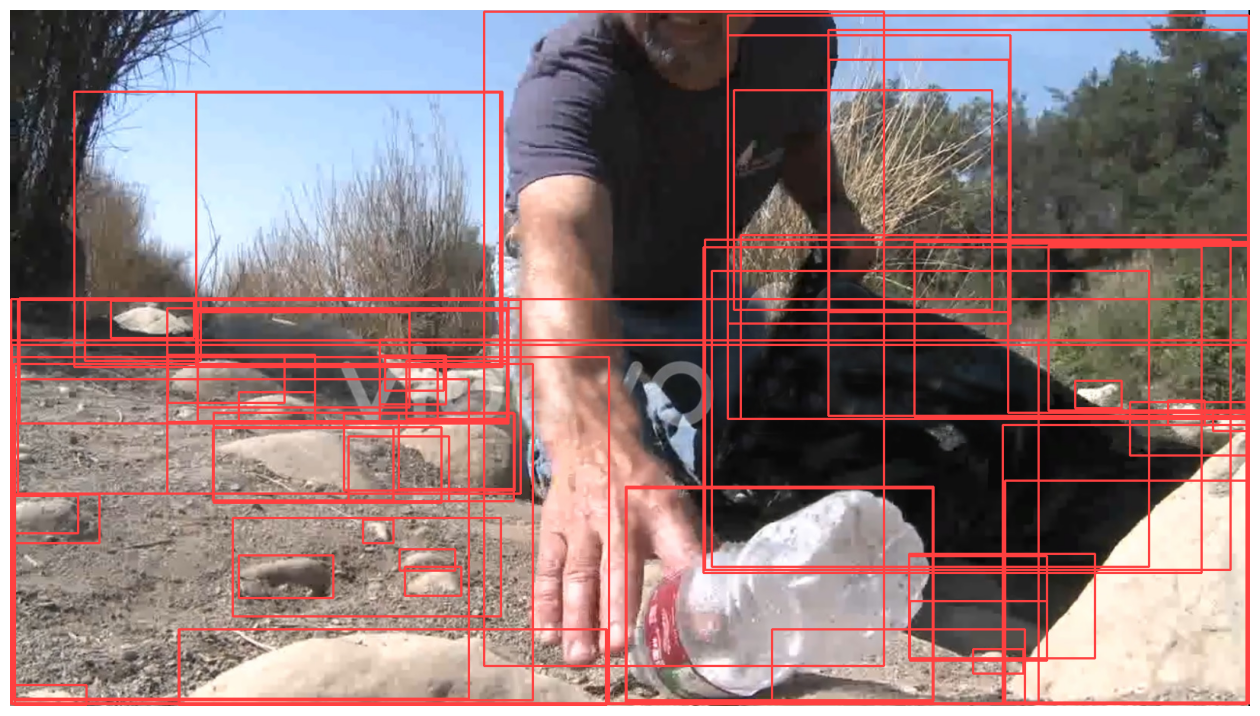

In [123]:
import cv2
import supervision
import numpy


box_annotator = supervision.BoxAnnotator()
detections = supervision.Detections(
    xyxy=results[0]["boxes"].numpy(),
    class_id=numpy.ones(results[0]["boxes"].shape[0], dtype=int)
) #, 2, 3, 4])#results[0]["labels"]

"""
labels = [
    f"{class_id} {confidence:0.2f}"
    for confidence, class_id, boxes in results
]
"""
annotated_frame = box_annotator.annotate(scene=image.copy(),
                                         detections=detections) #, labels=labels)

%matplotlib inline
supervision.plot_image(annotated_frame, (16, 16))